#MODELING SCALED OFFENSIVENESS IN GREEK TEXTS THROUGH REGRESSION WITH BEST0WORST SCALING AND PRETRAINED MODELS

#National and Kapodistrian University of Athens

#Department of Informatics and Telecommunications

#Program of Postgraduate Studies: (M.Sc.) in Language Technology

#Master's Thesis


#Balas Antonis (lt12100021)

In [ ]:
# Importing required libraries

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the folder containing the model results
folder = "/content/drive/MyDrive/MODELS/Regression/Best_Models/tweets+fiction/BERT/dimitriz-greek-media-bert-base-uncased/"

# Load the epoch-wise performance statistics from JSON
with open(os.path.join(folder,"statistics_per_epoch.json")) as f:
  d = json.load(f)

# Load general statistics that include the best training and evaluation epochs
with open(os.path.join(folder, "general_statistics.json")) as f:
  best_statics = json.load(f);
  best_epoch_train = best_statics['Best']['Training']['Epoch']      # Best epoch during training
  best_epoch_eval = best_statics['Best']['Evaluation']['Epoch']     # Best epoch during evaluation

# Create a DataFrame from the statistics of the best evaluation epoch
data_eval = pd.DataFrame.from_dict(d[str(best_epoch_eval)])

# Split the data into training and evaluation samples
data_train = data_eval[data_eval['Training'] == True]   # Rows belonging to the training set
data_eval = data_eval[data_eval['Training'] == False]   # Rows belonging to the evaluation set

In [ ]:
# 1 -> offensive
# 0 -> non-offensive

# Initialize a dictionary to store threshold-wise evaluation metrics
thres = {
    'threshold': [],
    'acc_less': [],            # Accuracy for samples with BWS <= threshold
    'acc_greater': [],         # Accuracy for samples with BWS > threshold
    'total_acc': [],           # Accuracy for all samples
    'total_cm': []             # Confusion matrix for all samples
}


# Iterate over thresholds from 0.1 to 1.0 in steps of 0.05
for threshold in  [round(i * 0.05, 2) for i in range(2, 21)]:
  # Split the evaluation data into two parts based on the threshold
  less_than_threshold = data_eval[(data_eval['BWS'] <= threshold)].copy()
  greater_than_threshold = data_eval[(data_eval['BWS'] > threshold)].copy()
  all_data = data_eval.copy()

  # Initialize metric placeholders
  cm_total = None
  acc = None
  acc_greater = None
  acc_less = None

  # Binarize the labels and predictions for "less than threshold" group
  less_than_threshold.loc[less_than_threshold['BWS'] > threshold, 'BWS'] = 1
  less_than_threshold.loc[less_than_threshold['BWS'] <= threshold, 'BWS'] = 0
  less_than_threshold.loc[less_than_threshold['Prediction'] > threshold, 'Prediction'] = 1
  less_than_threshold.loc[less_than_threshold['Prediction'] <= threshold, 'Prediction'] = 0

  less_than_threshold['BWS'] = less_than_threshold['BWS'].astype(int)
  less_than_threshold['Prediction'] = less_than_threshold['Prediction'].astype(int)

  # Binarize the labels and predictions for "greater than threshold" group
  greater_than_threshold.loc[greater_than_threshold['BWS'] > threshold, 'BWS'] = 1
  greater_than_threshold.loc[greater_than_threshold['BWS'] <= threshold, 'BWS'] = 0
  greater_than_threshold.loc[greater_than_threshold['Prediction'] > threshold, 'Prediction'] = 1
  greater_than_threshold.loc[greater_than_threshold['Prediction'] <= threshold, 'Prediction'] = 0

  greater_than_threshold['BWS'] = greater_than_threshold['BWS'].astype(int)
  greater_than_threshold['Prediction'] = greater_than_threshold['Prediction'].astype(int)

   # Binarize the full dataset for total accuracy and confusion matrix
  all_data.loc[all_data['BWS'] > threshold, 'BWS'] = 1
  all_data.loc[all_data['BWS'] <= threshold, 'BWS'] = 0
  all_data.loc[all_data['Prediction'] > threshold, 'Prediction'] = 1
  all_data.loc[all_data['Prediction'] <= threshold, 'Prediction'] = 0

  all_data['BWS'] = all_data['BWS'].astype(int)
  all_data['Prediction'] = all_data['Prediction'].astype(int)

  # Compute confusion matrix only if both classes exist
  if len(all_data['BWS'].unique()) > 1:
    cm_total = confusion_matrix(all_data['BWS'], all_data['Prediction'])

  # Compute overall accuracy if data is non-empty
  if len(all_data) != 0:
    acc = accuracy_score(all_data['BWS'], all_data['Prediction'])

  # Compute accuracy for greater group
  if len(greater_than_threshold) != 0:
    acc_greater = accuracy_score(greater_than_threshold['BWS'], greater_than_threshold['Prediction'])

   # Compute accuracy for less group
  if len(less_than_threshold) != 0:
    acc_less = accuracy_score(less_than_threshold['BWS'], less_than_threshold['Prediction'])

  # Store metrics in dictionary
  thres['threshold'].append(threshold)
  thres['acc_less'].append(acc_less)
  thres['acc_greater'].append(acc_greater)
  thres['total_acc'].append(acc)
  thres['total_cm'].append(cm_total)

# Convert results to DataFrame
thres = pd.DataFrame(thres)

# Display selected columns
thres[['threshold', 'acc_less', 'acc_greater', 'total_acc']]


,threshold,acc_less,acc_greater,total_acc
0,0.10,0.000000,1.000000,0.968711
1,0.15,0.028302,0.997989,0.933667
2,0.20,0.259067,0.980783,0.893617
3,0.25,0.447552,0.955793,0.864831
4,0.30,0.598916,0.903987,0.833542
5,0.35,0.660643,0.860909,0.798498
6,0.40,0.758092,0.818002,0.795995
7,0.45,0.787263,0.789535,0.788486
8,0.50,0.826542,0.772666,0.801627
9,0.55,0.858961,0.743511,0.811640


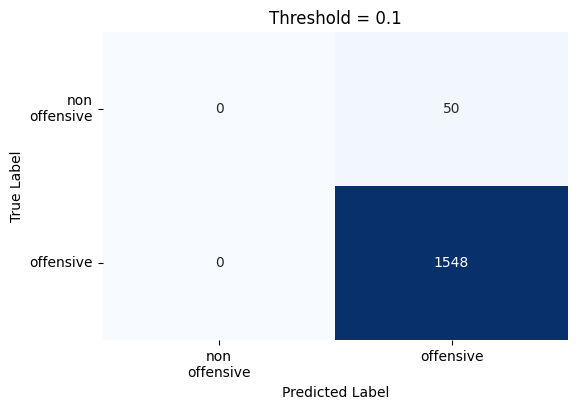

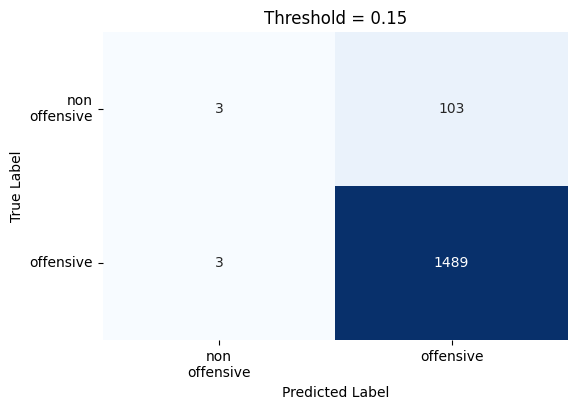

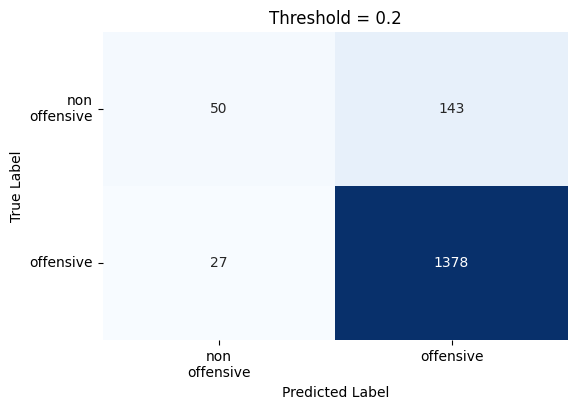

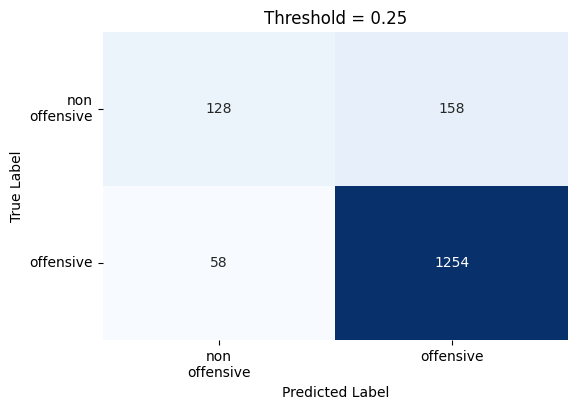

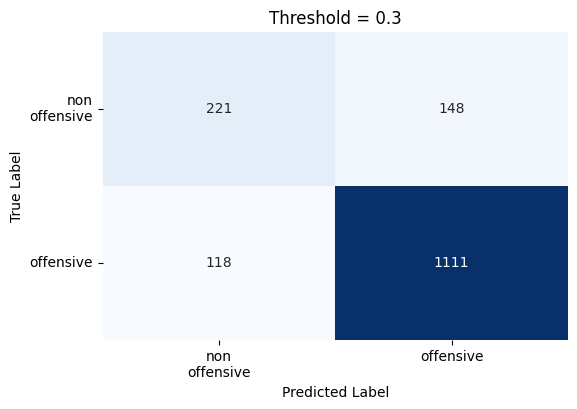

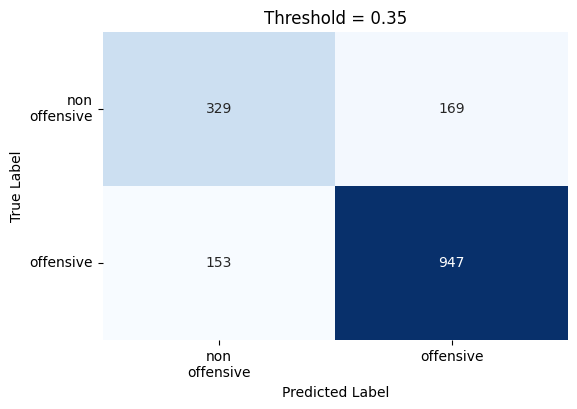

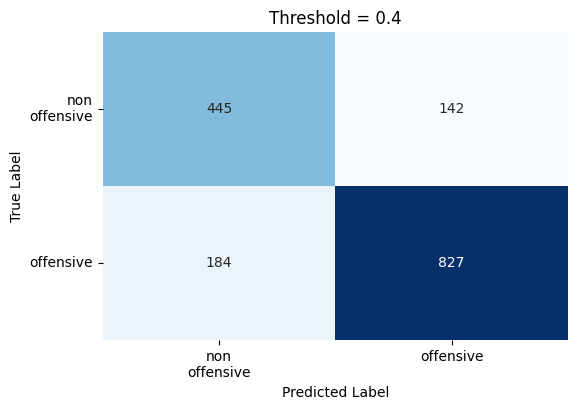

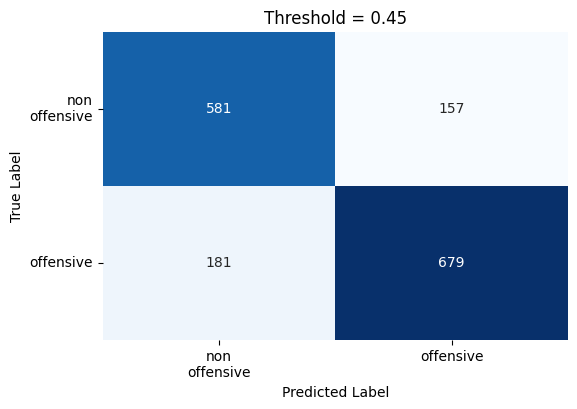

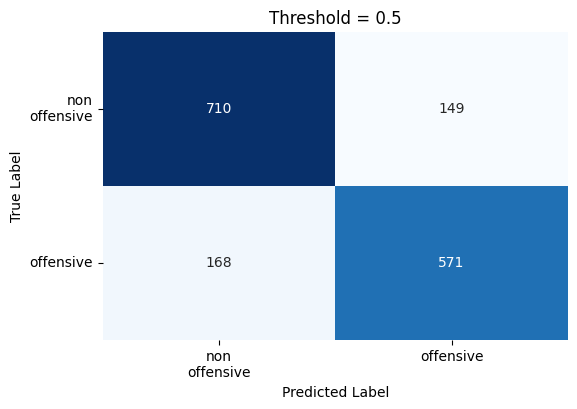

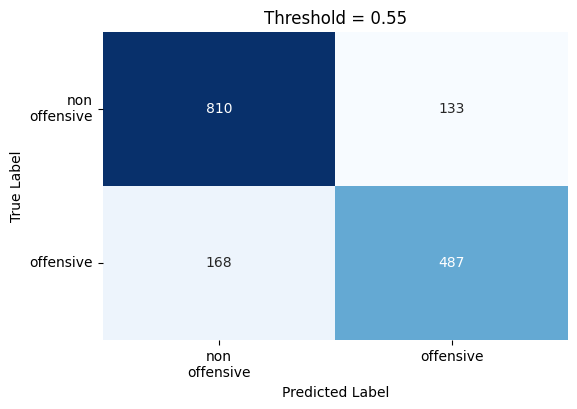

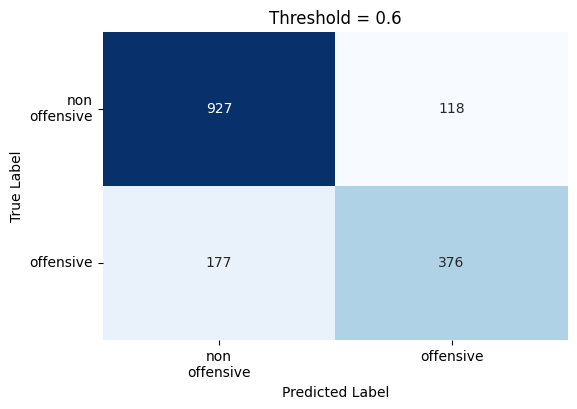

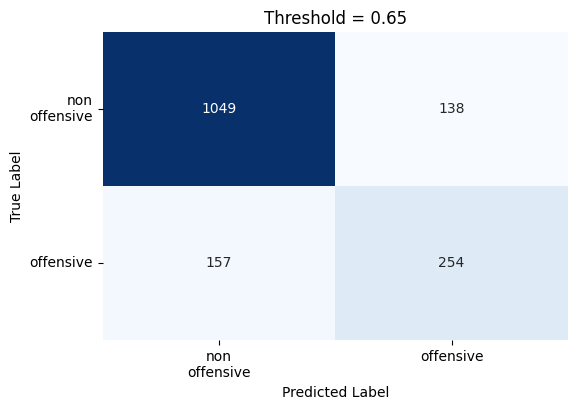

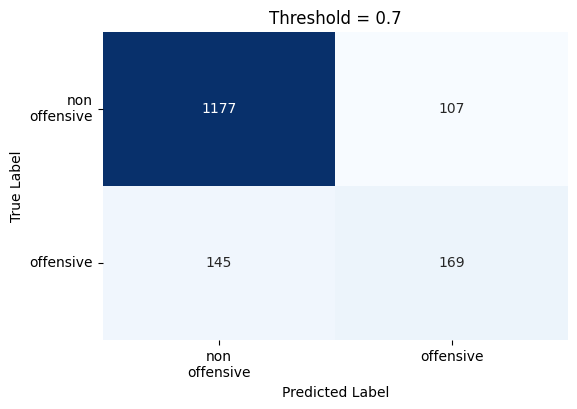

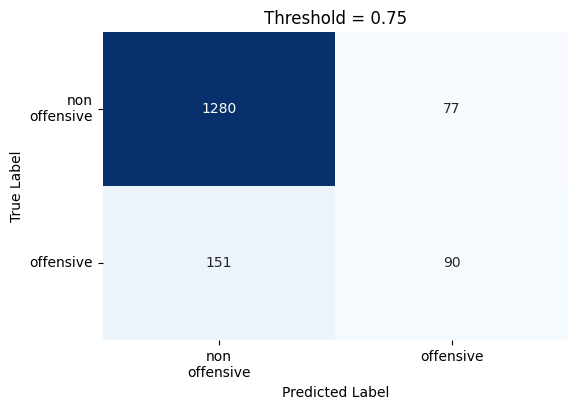

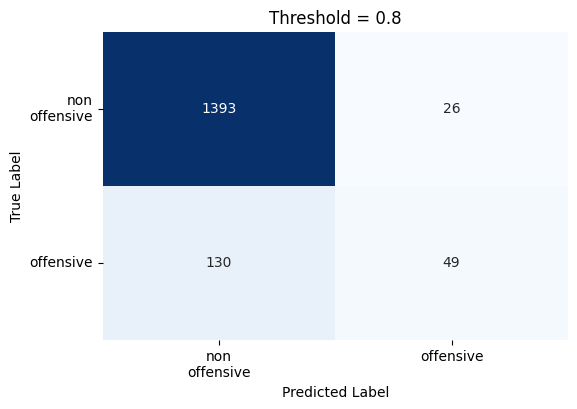

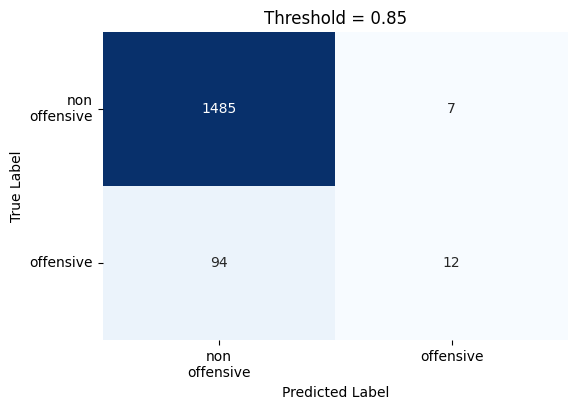

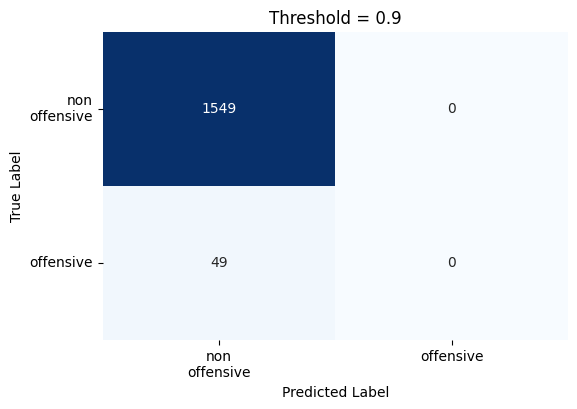

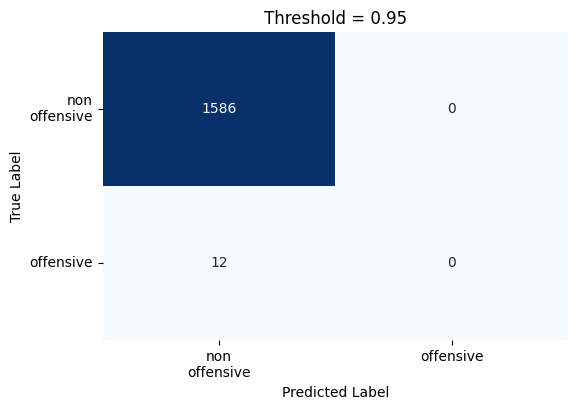

In [ ]:
# Iterate through each threshold row in the dataframe
for [threshold, _, _, _, cm] in thres.values:
    if cm is not None:
        # Create a new figure for the heatmap
        plt.figure(figsize=(6, 4))
        # Plot the confusion matrix as a heatmap
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

        # Set readable tick labels for x and y axes
        ax.set_xticklabels(["non\noffensive", "offensive"])
        ax.set_yticklabels(["non\noffensive", "offensive"], rotation=0)

        # Add title and axis labels
        plt.title(f"Threshold = {threshold}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        # Display the plot
        plt.show()

In [ ]:
# Save the threshold evaluation results to an Excel file
thres.to_excel(os.path.join(folder, "threshold_results.xlsx"))